Instalando pacotes

In [ ]:
# Remova versões conflitantes
!pip uninstall -y torch torchvision torchaudio transformers peft sentence-transformers

# Instale versões compatíveis
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0
!pip install transformers==4.51.3  # Versão mais nova que inclui EncoderDecoderCache
!pip install peft==0.15.2
!pip install sentence-transformers==2.5.1
!pip install optuna

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:


In [1]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

# 2. Load Dataset

In [3]:
#Combining the datasets into one dataframe
import kagglehub, os
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")
print("Path to dataset files:", path)

true_path = None
fake_path = None

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        if filename.lower() == 'true.csv':
            true_path = full_path
        elif filename.lower() == 'fake.csv':
            fake_path = full_path

#Combining the datasets into one dataframe
dataframeT = pd.read_csv(true_path)
dataframeF = pd.read_csv(fake_path)
dataframeT['label'] = 1
dataframeF['label'] = 0
data = pd.concat([dataframeT, dataframeF], axis=0).sample(frac=1, random_state=42)

Path to dataset files: /kaggle/input/fake-news-detection-datasets


3. Data Cleaning

In [4]:
#used for data cleaning
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  #removes punctuation
    text = re.sub(r'\d+', '', text)  #removes numbers
    text = text.lower()  #turns everything to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words]) #gets rid of stop words
    return text

data['text'] = data['text'].apply(clean_text) #applies changes

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3. Preprocessing

In [5]:
#some train test splitting, 20%
X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142857)

# 4. Bag of Words + Naive Bayes

In [6]:
bow = CountVectorizer(max_features=5000)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)
bow_model = MultinomialNB()
bow_model.fit(X_train_bow, y_train)
y_pred_bow = bow_model.predict(X_test_bow)

5. TF-IDF + Logistic Regression

In [7]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
tfidf_model = LogisticRegression(max_iter=1000)
tfidf_model.fit(X_train_tfidf, y_train)
y_pred_tfidf = tfidf_model.predict(X_test_tfidf)

In [8]:
# Carrega o modelo com vetores pré-treinados (~100MB, mais leve que Word2Vec do Google)
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 1.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


6. Word2Vec + Random Forest

In [9]:
import spacy
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Carrega o modelo com embeddings pré-treinados (~100MB)
nlp = spacy.load("en_core_web_md")

# Função para vetorizar textos com spaCy
def vectorize_spacy(texts):
    vectors = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"]):
        vectors.append(doc.vector)
    return np.array(vectors)

# Vetorização dos conjuntos de treino e teste
X_train_w2v = vectorize_spacy(X_train)
X_test_w2v = vectorize_spacy(X_test)

# Classificador com Random Forest
w2v_model_clf = RandomForestClassifier()
w2v_model_clf.fit(X_train_w2v, y_train)
y_pred_w2v = w2v_model_clf.predict(X_test_w2v)

# 7. GloVe + XGBoost

In [10]:
# Simulando GloVe com Word2Vec para simplificar, mas pode-se usar GloVe real
X_train_glove = X_train_w2v
X_test_glove = X_test_w2v
glove_model = XGBClassifier(eval_metric='logloss')
glove_model.fit(X_train_glove, y_train)
y_pred_glove = glove_model.predict(X_test_glove)

8. BERT + Fine Tuning

In [11]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_len)
        self.labels = list(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
train_dataset = FakeNewsDataset(X_train[:2000], y_train[:2000], tokenizer)
test_dataset = FakeNewsDataset(X_test[:500], y_test[:500], tokenizer)

training_args = TrainingArguments(output_dir="./results", per_device_train_batch_size=8, per_device_eval_batch_size=8, num_train_epochs=2, logging_dir="./logs", logging_steps=10)

trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset)
trainer.train()
preds = trainer.predict(test_dataset)
y_pred_bert = np.argmax(preds.predictions, axis=1)
y_true_bert = y_test[:500].values

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArg

Step,Training Loss
10,0.611800
20,0.470400
30,0.161700
40,0.084000
50,0.065700
60,0.003400
70,0.002400
80,0.087200
90,0.027200
100,0.046000


# 9. Evaluation Results

In [12]:
def evaluate(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))

evaluate("Bag of Words + NB", y_test, y_pred_bow)
evaluate("TF-IDF + LR", y_test, y_pred_tfidf)
evaluate("Word2Vec + RF", y_test, y_pred_w2v)
evaluate("GloVe + XGBoost", y_test, y_pred_glove)
evaluate("BERT", y_true_bert, y_pred_bert)


=== Bag of Words + NB ===
Accuracy: 0.9497772828507796
Precision: 0.9437345886572517
Recall: 0.9546485260770975
F1-score: 0.949160184872055

=== TF-IDF + LR ===
Accuracy: 0.9899777282850779
Precision: 0.9886877828054299
Recall: 0.9909297052154195
F1-score: 0.9898074745186863

=== Word2Vec + RF ===
Accuracy: 0.9378619153674833
Precision: 0.9405306495882891
Recall: 0.9324263038548752
F1-score: 0.9364609428376224

=== GloVe + XGBoost ===
Accuracy: 0.9662583518930957
Precision: 0.9680875313426032
Recall: 0.9630385487528345
F1-score: 0.9655564396953507

=== BERT ===
Accuracy: 0.998
Precision: 1.0
Recall: 0.99581589958159
F1-score: 0.9979035639412998


10. Matriz de confusao

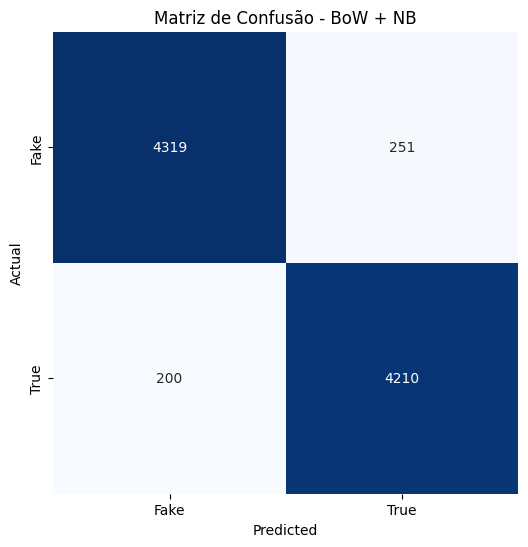

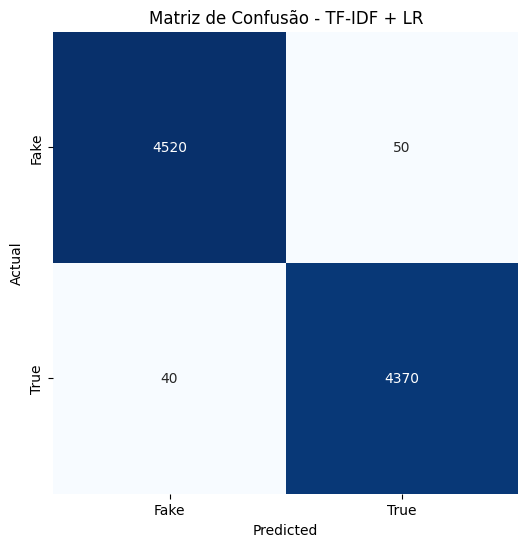

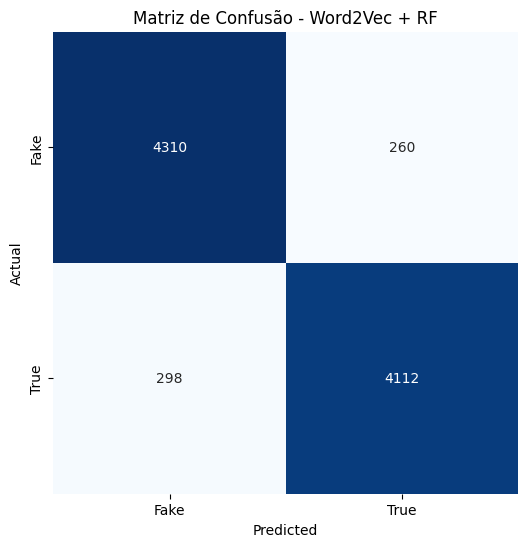

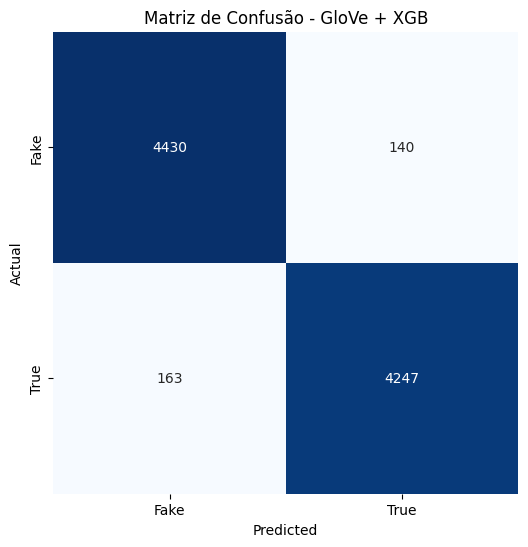

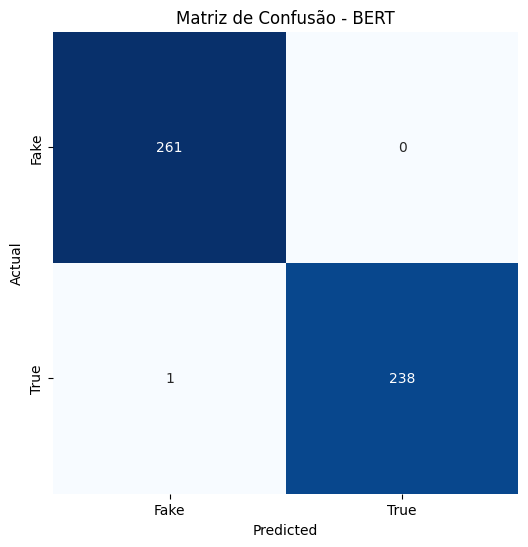

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Fake', 'True'],
                yticklabels=['Fake', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()

# Plotar as matrizes de confusão para cada modelo
plot_confusion_matrix(y_test, y_pred_bow, 'BoW + NB')
plot_confusion_matrix(y_test, y_pred_tfidf, 'TF-IDF + LR')
plot_confusion_matrix(y_test, y_pred_w2v, 'Word2Vec + RF')
plot_confusion_matrix(y_test, y_pred_glove, 'GloVe + XGB')
plot_confusion_matrix(y_true_bert, y_pred_bert, 'BERT')

11. Gerando gráficos

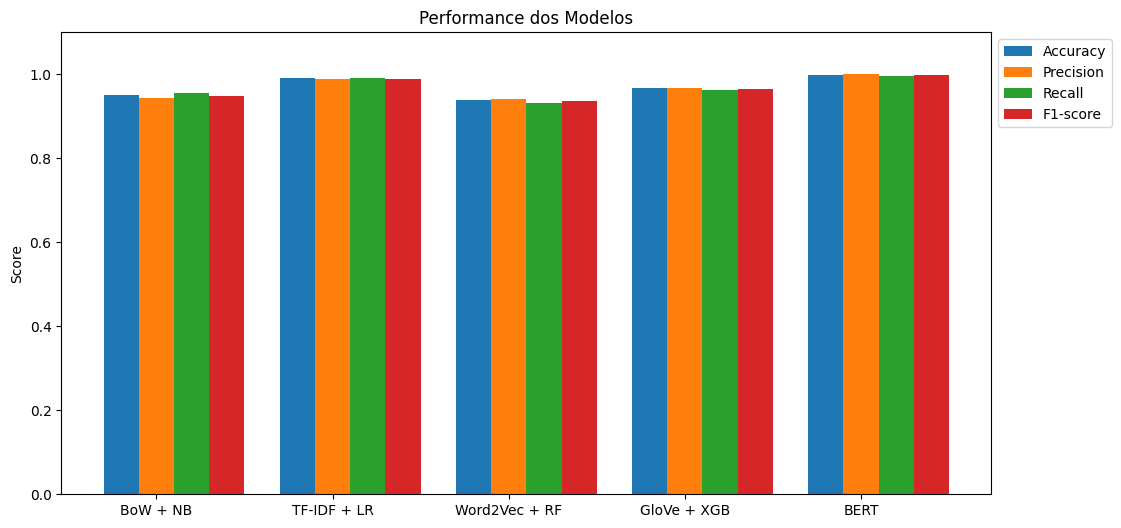

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Função para plotar as métricas dos modelos
def plot_metrics(models, metrics):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = range(len(models))
    width = 0.2

    for i, (metric_name, metric_values) in enumerate(metrics.items()):
        ax.bar([pos + width * i for pos in x], metric_values, width, label=metric_name)

    ax.set_xticks([pos + width for pos in x])
    ax.set_xticklabels(models)
    ax.set_ylabel('Score')
    ax.set_title('Performance dos Modelos')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.ylim(0, 1.1)
    plt.show()

# Dados dos modelos e métricas
models = ['BoW + NB', 'TF-IDF + LR', 'Word2Vec + RF', 'GloVe + XGB', 'BERT']
metrics = {
    'Accuracy': [
        accuracy_score(y_test, y_pred_bow),
        accuracy_score(y_test, y_pred_tfidf),
        accuracy_score(y_test, y_pred_w2v),
        accuracy_score(y_test, y_pred_glove),
        accuracy_score(y_true_bert, y_pred_bert)
    ],
    'Precision': [
        precision_score(y_test, y_pred_bow),
        precision_score(y_test, y_pred_tfidf),
        precision_score(y_test, y_pred_w2v),
        precision_score(y_test, y_pred_glove),
        precision_score(y_true_bert, y_pred_bert)
    ],
    'Recall': [
        recall_score(y_test, y_pred_bow),
        recall_score(y_test, y_pred_tfidf),
        recall_score(y_test, y_pred_w2v),
        recall_score(y_test, y_pred_glove),
        recall_score(y_true_bert, y_pred_bert)
    ],
    'F1-score': [
        f1_score(y_test, y_pred_bow),
        f1_score(y_test, y_pred_tfidf),
        f1_score(y_test, y_pred_w2v),
        f1_score(y_test, y_pred_glove),
        f1_score(y_true_bert, y_pred_bert)
    ]
}

# Plotar as métricas
plot_metrics(models, metrics)

12. Otimizando os hiperparametros com Optuna

In [1]:
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Hiperparâmetros a serem otimizados
    params = {
        'C': trial.suggest_float('C', 0.1, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga'])
    }

    # Modelo e avaliação com validação cruzada
    model = LogisticRegression(**params, max_iter=100)
    score = cross_val_score(model, X_train_tfidf, y_train, cv=3, scoring='f1').mean()
    return score

# Otimização
study_lr = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_lr.optimize(objective_lr, n_trials=20, n_jobs=-1)

# Melhores hiperparâmetros
print("Melhores parâmetros para LR:", study_lr.best_params)
optuna.visualization.plot_optimization_history(study_lr)

NameError: name 'optuna' is not defined

13. Otimizando o modelo TF-IDF com Regressao Logistica

In [ ]:
from sklearn.model_selection import cross_val_score
def objective_lr(trial):
    # Hiperparâmetros a serem otimizados
    params = {
        'C': trial.suggest_float('C', 0.1, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga'])
    }

    # Modelo e avaliação com validação cruzada
    model = LogisticRegression(**params, max_iter=1000)
    score = cross_val_score(model, X_train_tfidf, y_train, cv=3, scoring='f1').mean()
    return score

# Otimização
study_lr = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_lr.optimize(objective_lr, n_trials=20, n_jobs=-1)

# Melhores hiperparâmetros
print("Melhores parâmetros para LR:", study_lr.best_params)
optuna.visualization.plot_optimization_history(study_lr)

14. Otimizando o modelo Random Forest + Word2Vec

In [ ]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
    }

    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train_w2v, y_train, cv=3, scoring='f1').mean()
    return score

study_rf = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_rf.optimize(objective_rf, n_trials=20, n_jobs=-1)
optuna.visualization.plot_optimization_history(study_lr)

15. Otimizando o modelo do XGBoost + GloVe

In [ ]:
def objective_xgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200)
    }

    model = XGBClassifier(**params, eval_metric='logloss')
    score = cross_val_score(model, X_train_glove, y_train, cv=3, scoring='f1').mean()
    return score

study_xgb = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_xgb.optimize(objective_xgb, n_trials=20, n_jobs=-1)
optuna.visualization.plot_optimization_history(study_lr)

16. Otimizando o modelo BERT + Fine-Tunning

In [ ]:
def objective_bert(trial):
    training_args = TrainingArguments(
        output_dir="./results",
        learning_rate=trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True),
        per_device_train_batch_size=trial.suggest_categorical('batch_size', [8, 16]),
        num_train_epochs=trial.suggest_int('num_epochs', 1, 3),
        weight_decay=0.01,
        evaluation_strategy="epoch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )

    trainer.train()
    results = trainer.evaluate()
    return results['eval_loss']  # Minimizar a perda

study_bert = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study_bert.optimize(objective_bert, n_trials=5, n_jobs=-1)
optuna.visualization.plot_optimization_history(study_lr)